In [1]:
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler # Good practice for t-SNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc # For garbage collection

# --- Configuration ---
base_data_dir = "/home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings"
output_dir = "tsne_plots_arial_300dpi_v2" # Changed output dir name
os.makedirs(output_dir, exist_ok=True)

# --- Matplotlib Plotting Parameters ---
try:
    plt.rcParams['font.family'] = 'Arial'
except RuntimeError:
    print("Arial font not found. Using default Matplotlib font.")
plt.rcParams['font.size'] = 12
dpi_setting = 300

# --- Function to find all CSV files ---
def find_csv_files(directory):
    csv_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".csv"):
                csv_files.append(os.path.join(root, file))
    return csv_files

# --- Main Processing Loop ---
all_csv_files = find_csv_files(base_data_dir)

# !!! FOR DEBUGGING: Test with a single file first !!!
# all_csv_files = ["/home/pavitsingh/Desktop/naukri dot com/ChemT/datasets of 3 encodings/rdkit data/peptides_rdkit_descriptors.csv"]
# all_csv_files = ["/path/to/a/problematic/morgan_fps.csv"] # Example if you suspect a specific file type


if not all_csv_files:
    print(f"No CSV files found in {base_data_dir}")
else:
    print(f"Found {len(all_csv_files)} CSV files to process.")

for i, csv_filepath in enumerate(all_csv_files):
    filename = os.path.basename(csv_filepath)
    print(f"\n--- Processing file {i+1}/{len(all_csv_files)}: {filename} ---")

    try:
        print(f"  Loading CSV: {csv_filepath}")
        df = pd.read_csv(csv_filepath)
        print(f"  DataFrame shape: {df.shape}")

        if df.empty:
            print(f"  Skipping {filename}: CSV is empty.")
            continue

        # 1. Check for 'TASTE' column
        if "TASTE" not in df.columns:
            print(f"  Skipping {filename}: 'TASTE' column not found.")
            continue
        
        print(f"  'TASTE' column found. Value counts:\n{df['TASTE'].value_counts().to_string()}")

        # 2. Prepare features (X) and target (y)
        y = df["TASTE"]

        potential_id_cols = [
            'SMILES', 'smiles', 'Smiles', 
            'Name', 'name', 'NAME',
            'ID', 'Id', 'id', 
            ' molécule', 'molecule', 'Molecule',
            'Unnamed: 0' # Common index column
        ]
        # Filter out potential ID columns that are actually present in the dataframe
        actual_id_cols_to_drop = [col for col in potential_id_cols if col in df.columns]
        
        feature_candidates = [col for col in df.columns if col not in ['TASTE'] + actual_id_cols_to_drop]
        
        X = df[feature_candidates].select_dtypes(include=np.number)
        print(f"  Identified {X.shape[1]} numeric feature columns out of {len(feature_candidates)} candidates.")

        if X.shape[1] == 0:
            print(f"  Skipping {filename}: No numeric feature columns found after filtering.")
            continue
        
        if X.shape[1] > 500: # Arbitrary threshold for "high" dimensionality
            print(f"  WARNING: High number of features ({X.shape[1]}) for {filename}. "
                  "t-SNE can be very slow or memory-intensive. Consider PCA for dimensionality reduction first.")

        # 3. Handle NaNs in features
        if X.isnull().values.any():
            print(f"  NaNs found in features of {filename}. Dropping rows with NaNs for t-SNE.")
            nan_rows_before = X.isnull().any(axis=1).sum()
            valid_rows_mask = X.notnull().all(axis=1)
            X_clean = X[valid_rows_mask]
            y_clean = y[valid_rows_mask]
            print(f"  Dropped {nan_rows_before} rows containing NaNs. Shape of X_clean: {X_clean.shape}, y_clean: {y_clean.shape}")
            if X_clean.empty:
                print(f"  Skipping {filename}: No data left after NaN removal from features.")
                continue
        else:
            X_clean = X
            y_clean = y
            print("  No NaNs found in features.")
        
        n_samples = X_clean.shape[0]
        if n_samples < 2:
             print(f"  Skipping {filename}: Not enough samples ({n_samples}) after pre-processing for t-SNE.")
             continue

        # 3.5 Feature Scaling (often recommended for t-SNE)
        print("  Scaling features using StandardScaler...")
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)


        # 4. Apply t-SNE
        # Perplexity should be less than the number of samples.
        perplexity_val = min(30, n_samples - 1) 
        if perplexity_val < 1: # Ensure perplexity is at least 1
            perplexity_val = 1
        
        # If perplexity is very low, t-SNE might not be meaningful
        if n_samples > 1 and perplexity_val < 5 : # n_samples > 1 since perplexity_val could be 1 if n_samples = 2
             print(f"  Warning: Low perplexity ({perplexity_val}) for {filename} due to small sample size ({n_samples}). Results might be unstable.")

        print(f"  Running t-SNE on {X_scaled.shape[0]} samples and {X_scaled.shape[1]} features with perplexity {perplexity_val}...")
        tsne = TSNE(n_components=2, 
                    random_state=42, 
                    perplexity=perplexity_val,
                    n_iter=300, # Reduced for speed; default 1000. Increase for potentially better quality.
                    init='pca', 
                    learning_rate='auto'
                   )
        tsne_results = tsne.fit_transform(X_scaled)
        print("  t-SNE computation complete.")

        # 5. Create DataFrame for plotting
        plot_df = pd.DataFrame(data=tsne_results, columns=['tsne_1', 'tsne_2'])
        plot_df['TASTE'] = y_clean.values 

        # 6. Plotting
        plt.figure(figsize=(10, 8))
        
        num_unique_tastes = plot_df['TASTE'].nunique()
        if num_unique_tastes == 0:
            print(f"  Skipping plot for {filename}: No unique 'TASTE' values found after processing.")
            plt.close()
            continue

        palette = sns.color_palette("hsv", num_unique_tastes) if num_unique_tastes > 1 else ["#4C72B0"] # Use a single color if only one taste

        sns.scatterplot(
            x="tsne_1", y="tsne_2",
            hue="TASTE" if num_unique_tastes > 1 else None, # Only use hue if multiple tastes
            palette=palette if num_unique_tastes > 1 else None,
            data=plot_df,
            legend="full" if num_unique_tastes > 1 else False,
            alpha=0.7
        )
        
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)
        
        if num_unique_tastes > 1:
            plt.legend(title="TASTE", fontsize=10, title_fontsize=11)
        
        # 7. Save figure
        output_filename_base = os.path.splitext(filename)[0]
        output_image_path = os.path.join(output_dir, f"{output_filename_base}_tsne.png")
        
        plt.savefig(output_image_path, dpi=dpi_setting, bbox_inches='tight')
        plt.close() 

        print(f"  Saved t-SNE plot to {output_image_path}")

    except FileNotFoundError:
        print(f"  ERROR: File not found at {csv_filepath}")
    except pd.errors.EmptyDataError:
        print(f"  ERROR: Skipping {filename}: File is empty.")
    except ValueError as ve:
        print(f"  VALUE ERROR occurred while processing {filename}: {ve}")
        print(f"    Data shape at error (X_clean): {X_clean.shape if 'X_clean' in locals() else 'N/A'}")
        if plt.gcf().get_axes():
            plt.close()
    except Exception as e:
        print(f"  UNEXPECTED ERROR occurred while processing {filename}: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for unexpected errors
        if plt.gcf().get_axes():
            plt.close()
    finally:
        # Explicitly delete large objects and collect garbage
        if 'df' in locals(): del df
        if 'X' in locals(): del X
        if 'X_clean' in locals(): del X_clean
        if 'X_scaled' in locals(): del X_scaled
        if 'tsne_results' in locals(): del tsne_results
        if 'plot_df' in locals(): del plot_df
        gc.collect()
        print(f"  Finished processing {filename}. Cleaned up memory.")


print("\n--- All processing complete. ---")
print(f"Output plots are saved in the '{output_dir}' directory.")

Found 21 CSV files to process.

--- Processing file 1/21: molecules_rdkit_descriptors.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/rdkit data/molecules_rdkit_descriptors.csv
  DataFrame shape: (426, 209)
  'TASTE' column found. Value counts:
TASTE
1    299
0    127
  Identified 208 numeric feature columns out of 208 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 426 samples and 208 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/molecules_rdkit_descriptors_tsne.png
  Finished processing molecules_rdkit_descriptors.csv. Cleaned up memory.

--- Processing file 2/21: combined_rdkit_descriptors.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/rdkit data/combined_rdkit_descriptors.csv
  DataFrame shape: (868, 209)
  'TASTE' column found. Value counts:
TASTE
1    439
0    429
  Identified 208 numeric feature columns out of 208 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 868 samples and 208 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/combined_rdkit_descriptors_tsne.png
  Finished processing combined_rdkit_descriptors.csv. Cleaned up memory.

--- Processing file 3/21: peptides_rdkit_descriptors.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/rdkit data/peptides_rdkit_descriptors.csv
  DataFrame shape: (442, 209)
  'TASTE' column found. Value counts:
TASTE
0    302
1    140
  Identified 208 numeric feature columns out of 208 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 442 samples and 208 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/peptides_rdkit_descriptors_tsne.png
  Finished processing peptides_rdkit_descriptors.csv. Cleaned up memory.

--- Processing file 4/21: combined_all3.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/combined_all3.csv
  DataFrame shape: (868, 2557)
  'TASTE' column found. Value counts:
TASTE
1    439
0    429
  Identified 2556 numeric feature columns out of 2556 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 868 samples and 2556 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/combined_all3_tsne.png
  Finished processing combined_all3.csv. Cleaned up memory.

--- Processing file 5/21: molecules_mol2vec_rdkit.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/molecules_mol2vec_rdkit.csv
  DataFrame shape: (426, 509)
  'TASTE' column found. Value counts:
TASTE
1    299
0    127
  Identified 508 numeric feature columns out of 508 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 426 samples and 508 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/molecules_mol2vec_rdkit_tsne.png
  Finished processing molecules_mol2vec_rdkit.csv. Cleaned up memory.

--- Processing file 6/21: peptides_rdkit_morgan.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/peptides_rdkit_morgan.csv
  DataFrame shape: (442, 2257)
  'TASTE' column found. Value counts:
TASTE
0    302
1    140
  Identified 2256 numeric feature columns out of 2256 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 442 samples and 2256 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/peptides_rdkit_morgan_tsne.png
  Finished processing peptides_rdkit_morgan.csv. Cleaned up memory.

--- Processing file 7/21: molecules_morgan_mol2vec.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/molecules_morgan_mol2vec.csv
  DataFrame shape: (426, 2349)
  'TASTE' column found. Value counts:
TASTE
1    299
0    127
  Identified 2348 numeric feature columns out of 2348 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 426 samples and 2348 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/molecules_morgan_mol2vec_tsne.png
  Finished processing molecules_morgan_mol2vec.csv. Cleaned up memory.

--- Processing file 8/21: peptides_all3.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/peptides_all3.csv
  DataFrame shape: (442, 2557)
  'TASTE' column found. Value counts:
TASTE
0    302
1    140
  Identified 2556 numeric feature columns out of 2556 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 442 samples and 2556 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/peptides_all3_tsne.png
  Finished processing peptides_all3.csv. Cleaned up memory.

--- Processing file 9/21: molecules_rdkit_morgan.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/molecules_rdkit_morgan.csv
  DataFrame shape: (426, 2257)
  'TASTE' column found. Value counts:
TASTE
1    299
0    127
  Identified 2256 numeric feature columns out of 2256 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 426 samples and 2256 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/molecules_rdkit_morgan_tsne.png
  Finished processing molecules_rdkit_morgan.csv. Cleaned up memory.

--- Processing file 10/21: peptides_morgan_mol2vec.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/peptides_morgan_mol2vec.csv
  DataFrame shape: (442, 2349)
  'TASTE' column found. Value counts:
TASTE
0    302
1    140
  Identified 2348 numeric feature columns out of 2348 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 442 samples and 2348 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/peptides_morgan_mol2vec_tsne.png
  Finished processing peptides_morgan_mol2vec.csv. Cleaned up memory.

--- Processing file 11/21: combined_mol2vec_rdkit.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/combined_mol2vec_rdkit.csv
  DataFrame shape: (868, 509)
  'TASTE' column found. Value counts:
TASTE
1    439
0    429
  Identified 508 numeric feature columns out of 508 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 868 samples and 508 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/combined_mol2vec_rdkit_tsne.png
  Finished processing combined_mol2vec_rdkit.csv. Cleaned up memory.

--- Processing file 12/21: combined_morgan_mol2vec.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/combined_morgan_mol2vec.csv
  DataFrame shape: (868, 2349)
  'TASTE' column found. Value counts:
TASTE
1    439
0    429
  Identified 2348 numeric feature columns out of 2348 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 868 samples and 2348 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/combined_morgan_mol2vec_tsne.png
  Finished processing combined_morgan_mol2vec.csv. Cleaned up memory.

--- Processing file 13/21: peptides_mol2vec_rdkit.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/peptides_mol2vec_rdkit.csv
  DataFrame shape: (442, 509)
  'TASTE' column found. Value counts:
TASTE
0    302
1    140
  Identified 508 numeric feature columns out of 508 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 442 samples and 508 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/peptides_mol2vec_rdkit_tsne.png
  Finished processing peptides_mol2vec_rdkit.csv. Cleaned up memory.

--- Processing file 14/21: molecules_all3.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/molecules_all3.csv
  DataFrame shape: (426, 2557)
  'TASTE' column found. Value counts:
TASTE
1    299
0    127
  Identified 2556 numeric feature columns out of 2556 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 426 samples and 2556 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/molecules_all3_tsne.png
  Finished processing molecules_all3.csv. Cleaned up memory.

--- Processing file 15/21: combined_rdkit_morgan.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/ablation/combined_rdkit_morgan.csv
  DataFrame shape: (868, 2257)
  'TASTE' column found. Value counts:
TASTE
1    439
0    429
  Identified 2256 numeric feature columns out of 2256 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 868 samples and 2256 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/combined_rdkit_morgan_tsne.png
  Finished processing combined_rdkit_morgan.csv. Cleaned up memory.

--- Processing file 16/21: molecules_morgan_fps.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/morgan data/molecules_morgan_fps.csv
  DataFrame shape: (426, 2049)
  'TASTE' column found. Value counts:
TASTE
1    299
0    127
  Identified 2048 numeric feature columns out of 2048 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 426 samples and 2048 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/molecules_morgan_fps_tsne.png
  Finished processing molecules_morgan_fps.csv. Cleaned up memory.

--- Processing file 17/21: combined_morgan_fps.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/morgan data/combined_morgan_fps.csv
  DataFrame shape: (868, 2049)
  'TASTE' column found. Value counts:
TASTE
1    439
0    429
  Identified 2048 numeric feature columns out of 2048 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 868 samples and 2048 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/combined_morgan_fps_tsne.png
  Finished processing combined_morgan_fps.csv. Cleaned up memory.

--- Processing file 18/21: peptides_morgan_fps.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/morgan data/peptides_morgan_fps.csv
  DataFrame shape: (442, 2049)
  'TASTE' column found. Value counts:
TASTE
0    302
1    140
  Identified 2048 numeric feature columns out of 2048 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 442 samples and 2048 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/peptides_morgan_fps_tsne.png
  Finished processing peptides_morgan_fps.csv. Cleaned up memory.

--- Processing file 19/21: molecules_with_mol2vec.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/mol2vec data/molecules_with_mol2vec.csv
  DataFrame shape: (426, 301)
  'TASTE' column found. Value counts:
TASTE
1    299
0    127
  Identified 300 numeric feature columns out of 300 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 426 samples and 300 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/molecules_with_mol2vec_tsne.png
  Finished processing molecules_with_mol2vec.csv. Cleaned up memory.

--- Processing file 20/21: combined_with_mol2vec.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/mol2vec data/combined_with_mol2vec.csv
  DataFrame shape: (868, 301)
  'TASTE' column found. Value counts:
TASTE
1    439
0    429
  Identified 300 numeric feature columns out of 300 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 868 samples and 300 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/combined_with_mol2vec_tsne.png
  Finished processing combined_with_mol2vec.csv. Cleaned up memory.

--- Processing file 21/21: peptides_with_mol2vec.csv ---
  Loading CSV: /home/pavit21178/BTP/redoing_work/pipeline_work/datasets of 3 encodings/mol2vec data/peptides_with_mol2vec.csv
  DataFrame shape: (442, 301)
  'TASTE' column found. Value counts:
TASTE
0    302
1    140
  Identified 300 numeric feature columns out of 300 candidates.
  No NaNs found in features.
  Scaling features using StandardScaler...
  Running t-SNE on 442 samples and 300 features with perplexity 30...


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  t-SNE computation complete.


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

  Saved t-SNE plot to tsne_plots_arial_300dpi_v2/peptides_with_mol2vec_tsne.png
  Finished processing peptides_with_mol2vec.csv. Cleaned up memory.

--- All processing complete. ---
Output plots are saved in the 'tsne_plots_arial_300dpi_v2' directory.


--- Peptide Data Analytics from '/home/pavit21178/BTP/redoing_work/datasets_base/peptides.csv' ---

Total peptides in dataset: 442

Calculating molecular weights (this may take a moment for large datasets)...
--------------------------------------------------

--- Overall Descriptive Statistics ---

🔬 Sequence Length:
  Min Length:    2
  Max Length:    39
  Average Length: 5.12
  Median Length:  3.5

🔬 Molecular Weight (g/mol):
  Min Weight:    172.18
  Max Weight:    4296.95
  Average Weight: 582.54
  Median Weight:  407.38
--------------------------------------------------

--- Taste Class Distribution ---
TASTE
0    302
1    140
Name: count, dtype: int64
--------------------------------------------------

--- Statistics Grouped by Taste Class ---

🔬 By Sequence Length:
 TASTE  count  avg_length  median_length  min_length  max_length
     0    302        5.56           4.00           2          39
     1    140        4.16           3.00           2          14

🔬 By Molecular Weigh

/tmp/ipykernel_2109596/1711927298.py:152: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TASTE', data=df, palette='viridis')


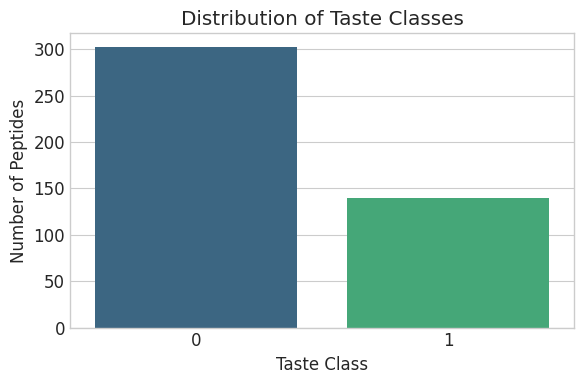

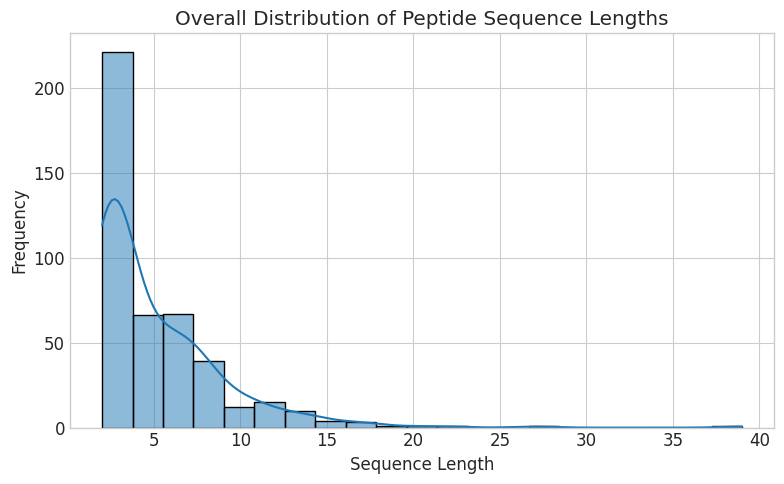

/tmp/ipykernel_2109596/1711927298.py:173: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TASTE', y='LENGTH', data=df, palette='pastel')


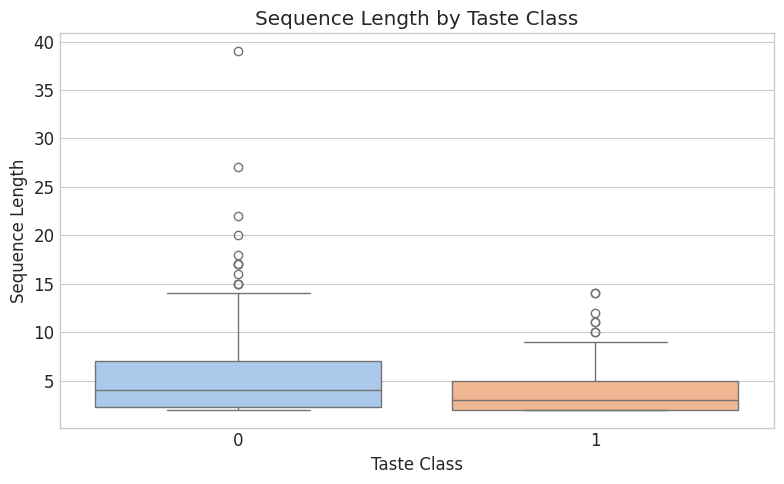

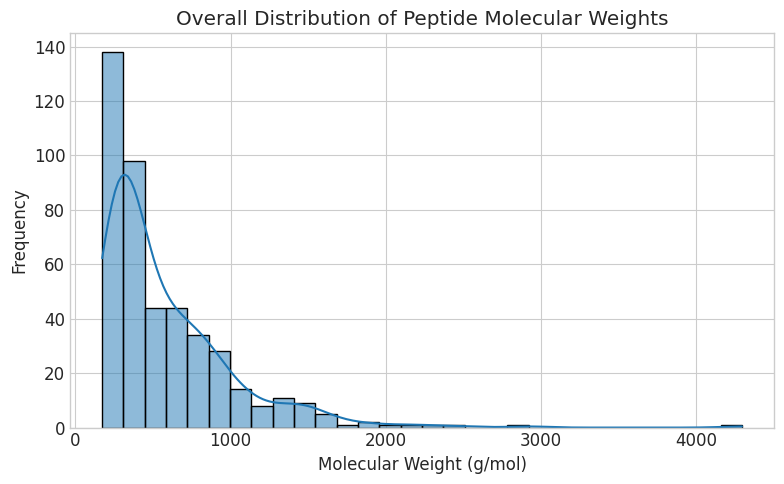

/tmp/ipykernel_2109596/1711927298.py:196: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='TASTE', y='MOLECULAR_WEIGHT', data=df, palette='pastel')


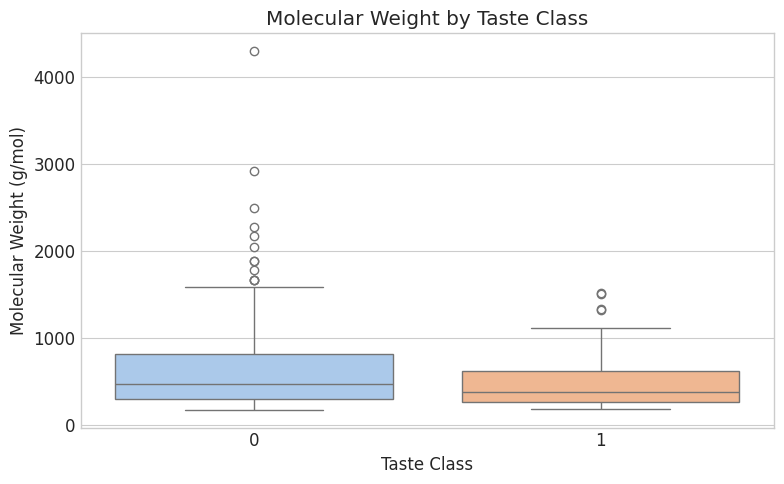

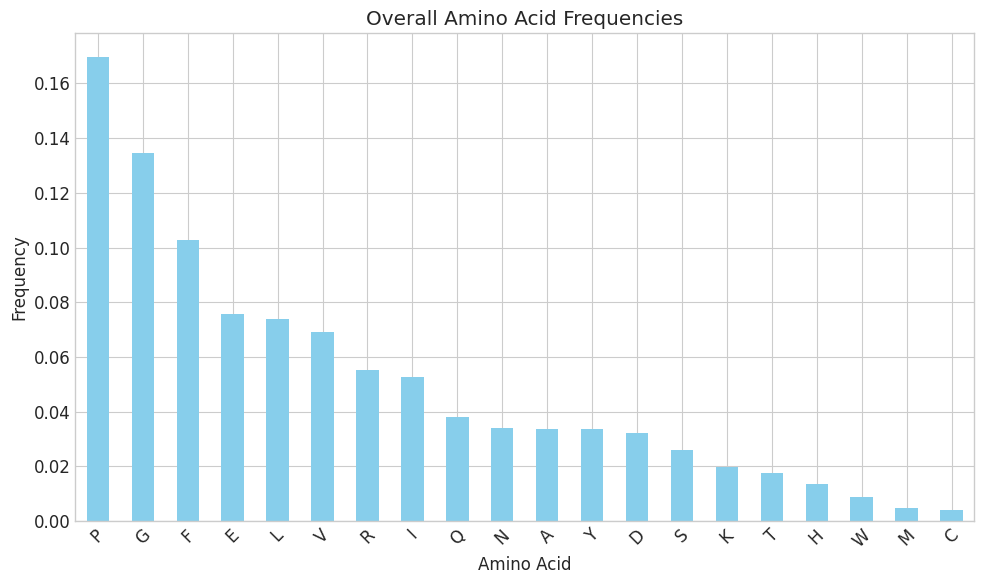


--- Analysis Complete. Plots saved as PNG files in the script's directory. ---


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np # For NaN if SMILES parsing fails

# --- RDKit for Molecular Weight ---
# RDKit can be tricky to install sometimes.
# If you don't have it or don't want to install it,
# you can comment out the RDKit sections.
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors
    RDKIT_AVAILABLE = True
except ImportError:
    RDKIT_AVAILABLE = False
    print("⚠️ RDKit not found. Molecular weight calculations will be skipped.")
    print("  To install: pip install rdkit-pypi or conda install -c conda-forge rdkit")

# --- Configuration ---
FILE_PATH = "/home/pavit21178/BTP/redoing_work/datasets_base/peptides.csv" # Make sure this path is correct

# --- Helper Functions ---
def calculate_molecular_weight(smiles):
    if not RDKIT_AVAILABLE or pd.isna(smiles):
        return np.nan
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            return Descriptors.MolWt(mol)
        else:
            return np.nan # Invalid SMILES
    except Exception:
        return np.nan # Other RDKit errors

def get_amino_acid_frequencies(sequences_series):
    """Calculates amino acid frequencies from a pandas Series of sequences."""
    all_aas_string = "".join(sequences_series.dropna())
    aa_counts = Counter(all_aas_string)
    total_aas = sum(aa_counts.values())
    aa_frequencies = {aa: count / total_aas for aa, count in aa_counts.items()}
    return pd.Series(aa_frequencies).sort_values(ascending=False)

# --- Main Analysis ---
def analyze_peptides(file_path):
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        print(f"❌ Error: File not found at '{file_path}'. Please check the path.")
        return

    print(f"--- Peptide Data Analytics from '{file_path}' ---\n")
    print(f"Total peptides in dataset: {len(df)}\n")

    # --- 1. Data Cleaning and Preprocessing ---
    # Ensure TASTE is integer (if it's read as float, e.g. 1.0)
    if 'TASTE' in df.columns and df['TASTE'].notna().all():
        # Check if it's float and can be converted to int without loss
        if pd.api.types.is_float_dtype(df['TASTE']) and (df['TASTE'] == df['TASTE'].astype(int)).all():
            df['TASTE'] = df['TASTE'].astype(int)
    else:
        print("⚠️ 'TASTE' column not found or contains NaNs. Taste-based analysis will be limited.")


    # Calculate Sequence Length
    if 'SEQUENCE' not in df.columns:
        print("❌ Error: 'SEQUENCE' column not found. Cannot perform sequence-based analysis.")
        return
    df['LENGTH'] = df['SEQUENCE'].astype(str).apply(len) # astype(str) in case of NaNs

    # Calculate Molecular Weight (if RDKit is available and SMILES column exists)
    if RDKIT_AVAILABLE and 'SMILES' in df.columns:
        print("Calculating molecular weights (this may take a moment for large datasets)...")
        df['MOLECULAR_WEIGHT'] = df['SMILES'].apply(calculate_molecular_weight)
        mw_na_count = df['MOLECULAR_WEIGHT'].isna().sum()
        if mw_na_count > 0:
            print(f"⚠️ Could not calculate molecular weight for {mw_na_count} entries (invalid SMILES or missing).")
    elif 'SMILES' not in df.columns and RDKIT_AVAILABLE:
        print("ℹ️ 'SMILES' column not found. Molecular weight calculations will be skipped.")
    print("-" * 50)

    # --- 2. Overall Descriptive Statistics ---
    print("\n--- Overall Descriptive Statistics ---")
    print("\n🔬 Sequence Length:")
    print(f"  Min Length:    {df['LENGTH'].min()}")
    print(f"  Max Length:    {df['LENGTH'].max()}")
    print(f"  Average Length: {df['LENGTH'].mean():.2f}")
    print(f"  Median Length:  {df['LENGTH'].median()}")

    if 'MOLECULAR_WEIGHT' in df.columns and df['MOLECULAR_WEIGHT'].notna().any():
        print("\n🔬 Molecular Weight (g/mol):")
        print(f"  Min Weight:    {df['MOLECULAR_WEIGHT'].min():.2f}")
        print(f"  Max Weight:    {df['MOLECULAR_WEIGHT'].max():.2f}")
        print(f"  Average Weight: {df['MOLECULAR_WEIGHT'].mean():.2f}")
        print(f"  Median Weight:  {df['MOLECULAR_WEIGHT'].median():.2f}")
    print("-" * 50)

    # --- 3. Taste Class Distribution ---
    if 'TASTE' in df.columns:
        print("\n--- Taste Class Distribution ---")
        taste_counts = df['TASTE'].value_counts(dropna=False) # include NaNs if any
        print(taste_counts)
        print("-" * 50)

        # --- 4. Statistics Grouped by Taste Class ---
        print("\n--- Statistics Grouped by Taste Class ---")
        if taste_counts.empty or len(taste_counts) < 2:
            print("ℹ️ Not enough taste classes or data to perform robust grouped statistics.")
        else:
            grouped_stats = df.groupby('TASTE').agg(
                count=('SEQUENCE', 'size'),
                avg_length=('LENGTH', 'mean'),
                median_length=('LENGTH', 'median'),
                min_length=('LENGTH', 'min'),
                max_length=('LENGTH', 'max'),
                avg_mw=('MOLECULAR_WEIGHT', 'mean' if 'MOLECULAR_WEIGHT' in df.columns else lambda x: np.nan),
                median_mw=('MOLECULAR_WEIGHT', 'median' if 'MOLECULAR_WEIGHT' in df.columns else lambda x: np.nan),
                min_mw=('MOLECULAR_WEIGHT', 'min' if 'MOLECULAR_WEIGHT' in df.columns else lambda x: np.nan),
                max_mw=('MOLECULAR_WEIGHT', 'max' if 'MOLECULAR_WEIGHT' in df.columns else lambda x: np.nan)
            ).reset_index()

            print("\n🔬 By Sequence Length:")
            print(grouped_stats[['TASTE', 'count', 'avg_length', 'median_length', 'min_length', 'max_length']].to_string(index=False, float_format="%.2f"))

            if 'MOLECULAR_WEIGHT' in df.columns and grouped_stats['avg_mw'].notna().any():
                print("\n🔬 By Molecular Weight (g/mol):")
                print(grouped_stats[['TASTE', 'count', 'avg_mw', 'median_mw', 'min_mw', 'max_mw']].to_string(index=False, float_format="%.2f"))
            print("-" * 50)

    # --- 5. Amino Acid Frequencies ---
    print("\n--- Amino Acid Frequencies ---")
    print("\nOverall Amino Acid Frequencies:")
    overall_aa_freq = get_amino_acid_frequencies(df['SEQUENCE'])
    print(overall_aa_freq.head(10)) # Print top 10

    if 'TASTE' in df.columns and not taste_counts.empty and len(taste_counts) >= 2:
        print("\nAmino Acid Frequencies by Taste Class (Top 5 per class):")
        for taste_val, group_df in df.groupby('TASTE'):
            if not group_df.empty:
                print(f"\nTaste Class {taste_val}:")
                taste_aa_freq = get_amino_acid_frequencies(group_df['SEQUENCE'])
                print(taste_aa_freq.head(5))
    print("-" * 50)

    # --- 6. Plotting ---
    print("\n--- Generating Plots ---")
    plt.style.use('seaborn-v0_8-whitegrid') # Using a seaborn style

    # Plot 1: Taste Distribution
    if 'TASTE' in df.columns and not taste_counts.empty:
        plt.figure(figsize=(6, 4))
        sns.countplot(x='TASTE', data=df, palette='viridis')
        plt.title('Distribution of Taste Classes')
        plt.xlabel('Taste Class')
        plt.ylabel('Number of Peptides')
        plt.tight_layout()
        plt.savefig('taste_distribution.png')
        plt.show()

    # Plot 2: Sequence Length Distribution (Overall)
    plt.figure(figsize=(8, 5))
    sns.histplot(df['LENGTH'], kde=True, bins=max(10, min(df['LENGTH'].nunique(), 30))) # Dynamic bins
    plt.title('Overall Distribution of Peptide Sequence Lengths')
    plt.xlabel('Sequence Length')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('length_distribution_overall.png')
    plt.show()

    # Plot 3: Sequence Length by Taste (Box Plot)
    if 'TASTE' in df.columns and not taste_counts.empty and len(taste_counts) >= 2:
        plt.figure(figsize=(8, 5))
        sns.boxplot(x='TASTE', y='LENGTH', data=df, palette='pastel')
        plt.title('Sequence Length by Taste Class')
        plt.xlabel('Taste Class')
        plt.ylabel('Sequence Length')
        plt.tight_layout()
        plt.savefig('length_by_taste.png')
        plt.show()

    # Plot 4 & 5: Molecular Weight (if available)
    if 'MOLECULAR_WEIGHT' in df.columns and df['MOLECULAR_WEIGHT'].notna().any():
        # Plot 4: Molecular Weight Distribution (Overall)
        plt.figure(figsize=(8, 5))
        sns.histplot(df['MOLECULAR_WEIGHT'].dropna(), kde=True, bins=max(10, min(df['MOLECULAR_WEIGHT'].nunique(), 30)))
        plt.title('Overall Distribution of Peptide Molecular Weights')
        plt.xlabel('Molecular Weight (g/mol)')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.savefig('mw_distribution_overall.png')
        plt.show()

        # Plot 5: Molecular Weight by Taste (Box Plot)
        if 'TASTE' in df.columns and not taste_counts.empty and len(taste_counts) >= 2:
            plt.figure(figsize=(8, 5))
            sns.boxplot(x='TASTE', y='MOLECULAR_WEIGHT', data=df, palette='pastel')
            plt.title('Molecular Weight by Taste Class')
            plt.xlabel('Taste Class')
            plt.ylabel('Molecular Weight (g/mol)')
            plt.tight_layout()
            plt.savefig('mw_by_taste.png')
            plt.show()

    # Plot 6: Overall Amino Acid Frequencies
    if not overall_aa_freq.empty:
        plt.figure(figsize=(10, 6))
        overall_aa_freq.plot(kind='bar', color='skyblue')
        plt.title('Overall Amino Acid Frequencies')
        plt.xlabel('Amino Acid')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('aa_frequency_overall.png')
        plt.show()

    print("\n--- Analysis Complete. Plots saved as PNG files in the script's directory. ---")

# --- Run the analysis ---
if __name__ == "__main__":
    analyze_peptides(FILE_PATH)

Okay, this is a great task! I will go through each paper carefully, extract the relevant machine learning metrics for umami taste prediction/classification, and then compile them into a competitor analysis table.

Let's start by thoroughly parsing each paper.

**Paper 1: "Computational Screening of Umami Tastants Using Deep Learning" by Dutta et al.**

*   **Main Models Developed by Dutta et al.:**
    1.  **Umami Classification Model:**
        *   Dataset: Combined (Patent + UMP442) - 439 umami, 428 non-umami.
        *   Training: 693 records, Test: 174 records.
        *   Architecture: TabPFN (transformer-based).
        *   **Performance on their full Test Set (Table 1, Page 15):**
            *   Accuracy: 0.93
            *   Balanced Accuracy: 0.93
            *   Sensitivity: 0.93
            *   Specificity: 0.93
            *   F1-score: 0.93
            *   ROC-AUC: 0.93
    2.  **Umami Potency Prediction Model:** (Classifying high vs. low potency based on EC50 < 2 µM)
        *   Dataset: Patent data only (299 umami tastants).
        *   Training: 239 records (after SMOTE), Test: 60 records.
        *   Architecture: DNN (multilayer perceptron).
        *   **Performance on their Test Set (Table 3, Page 18):**
            *   Accuracy: 0.82
            *   Precision: 0.88
            *   Recall: 0.90
            *   F1-score: 0.89

*   **Comparison with Existing Literature (Dutta et al. evaluating others on UMP-IND set - Table 2, Page 17):**
    *   Dataset for this comparison: UMP-IND set (subset of their test set: 28 umami, 61 non-umami).
    *   **Dutta et al.'s TabPFN model (on UMP-IND):**
        *   Accuracy: 0.899
        *   Sensitivity: 0.821
        *   Specificity: 0.934
        *   ROC-AUC: 0.878
    *   **iUmami-SCM [16] (as evaluated by Dutta et al. on UMP-IND):**
        *   Accuracy: 0.865
        *   Sensitivity: 0.714
        *   Specificity: 0.934
        *   ROC-AUC: 0.898
    *   **UMPred-FRL [17] (as evaluated by Dutta et al. on UMP-IND):**
        *   Accuracy: 0.888
        *   Sensitivity: 0.786
        *   Specificity: 0.934
        *   ROC-AUC: 0.919
    *   **VirtuousUmami [18] (as evaluated by Dutta et al. on UMP-IND):**
        *   Accuracy: 0.876
        *   Sensitivity: 0.786
        *   Specificity: 0.918
        *   ROC-AUC: 0.85

**Paper 2: "UmamiPreDL: Deep Learning model for umami taste prediction of peptides using BERT and CNN" by Pandiyan et al.**

*   **Main Models Developed by Pandiyan et al. (Table 1, Page 15):**
    *   Dataset: UMP-TR, UMP-IND + literature (76+37 umami peptides, 315 bitter peptides as negative control). 80:20 train/validation split. Performance on 5-fold cross-validation.
    *   **1. ProtBert-CNN (Their best model):**
        *   ACC*: 94%
        *   AUC ROC*: 0.954
        *   MCC*: 0.891
        *   F1*: 0.929
        *   Specificity: 89%
        *   Sensitivity: 98%
    *   **2. ESM-2-CNN:**
        *   ACC*: 86%
        *   AUC ROC*: 0.865
        *   MCC*: 0.725
        *   F1*: 0.851
        *   Specificity: 80%
        *   Sensitivity: 92%
    *   **3. ESM-2-DNN:**
        *   ACC*: 82%
        *   AUC ROC*: 0.824
        *   MCC*: 0.644
        *   F1*: 0.824
        *   Specificity: 76%
        *   Sensitivity: 88%
    *   **4. ProtBert-DNN:**
        *   ACC*: 76%
        *   AUC ROC*: 0.771
        *   MCC*: 0.501
        *   F1*: 0.666
        *   Specificity: 58%
        *   Sensitivity: 89%

*   **Comparison with Published Methods (Pandiyan et al. citing others - Table 2, Page 16):**
    *   **iUmami-SCM (Charoenkwan et al., 2020):**
        *   Reported accuracy (BACC/ACC): 86.5%
        *   Mathew Correlation Coefficient (MCC): 0.679
        *   (F1 score: Not shown in this table by Pandiyan)
    *   **VirtuousUmami (Pallante et al., 2022):**
        *   Reported accuracy (BACC/ACC): 87.6%
        *   MCC: NA
        *   (F1 score: 79.3 mentioned in text)
    *   **UMPred-FRL (Charoenkwan et al., 2021):**
        *   Reported accuracy (BACC/ACC): 88.9%
        *   MCC: 0.735
    *   **IUP-BERT (Jiang et al., 2022):**
        *   Reported accuracy (BACC/ACC): 89.6%
        *   MCC: 0.793
    *   **Umami-MRNN (Qi et al., 2023):**
        *   Reported accuracy (BACC/ACC): 90.5%
        *   MCC: 0.811
    *   **Umami_YYDS (Cui et al., 2023):**
        *   Reported accuracy (BACC/ACC): 89.6%
        *   MCC: NA

Now, let's construct the competitor analysis table. I will try to create a comprehensive table, noting when metrics are directly from the paper's own model vs. when they are citing/evaluating a competitor.

**Competitor Analysis Table: Umami Taste Prediction/Classification Models**

| Model Name         | Reported By / Evaluated By | Task / Key Dataset Feature                 | Accuracy (ACC) | Sensitivity (Recall) | Specificity | ROC-AUC | F1-Score | Precision | MCC    | Notes                                                                 |
| :----------------- | :------------------------- | :----------------------------------------- | :------------- | :------------------- | :---------- | :------ | :------- | :-------- | :----- | :-------------------------------------------------------------------- |
| **Dutta et al. Models** |                            |                                            |                |                      |             |         |          |           |        |                                                                       |
| TabPFN (Umami Class.)| Dutta et al. (2024)        | Umami vs. Non-Umami (Full Test Set)        | 0.93           | 0.93                 | 0.93        | 0.93    | 0.93     | N/R       | N/R    | Also Bal. Acc: 0.93                                                     |
| DNN (Umami Potency) | Dutta et al. (2024)        | High vs. Low Potency (Patent Data Test)    | 0.82           | 0.90                 | N/R         | N/R     | 0.89     | 0.88      | N/R    |                                                                       |
| TabPFN (Umami Class.)| Dutta et al. (2024)        | Umami vs. Non-Umami (UMP-IND set)          | 0.899          | 0.821                | 0.934       | 0.878   | N/R      | N/R       | N/R    | Dutta's model evaluated on this specific subset for comparison        |
| **Pandiyan et al. Models** |                        |                                            |                |                      |             |         |          |           |        |                                                                       |
| ProtBert-CNN       | Pandiyan et al. (preprint) | Umami Peptide vs. Bitter Peptide (5-fold CV) | 0.94           | 0.98                 | 0.89        | 0.954   | 0.929    | N/R       | 0.891  | Their best model                                                      |
| ESM-2-CNN          | Pandiyan et al. (preprint) | Umami Peptide vs. Bitter Peptide (5-fold CV) | 0.86           | 0.92                 | 0.80        | 0.865   | 0.851    | N/R       | 0.725  |                                                                       |
| ESM-2-DNN          | Pandiyan et al. (preprint) | Umami Peptide vs. Bitter Peptide (5-fold CV) | 0.82           | 0.88                 | 0.76        | 0.824   | 0.824    | N/R       | 0.644  |                                                                       |
| ProtBert-DNN       | Pandiyan et al. (preprint) | Umami Peptide vs. Bitter Peptide (5-fold CV) | 0.76           | 0.89                 | 0.58        | 0.771   | 0.666    | N/R       | 0.501  |                                                                       |
| **Competitor Models (as evaluated/cited by Dutta et al. on UMP-IND set)** | |          |                |                      |             |         |          |           |        |                                                                       |
| iUmami-SCM [16]    | Dutta et al. (2024)        | Umami vs. Non-Umami (UMP-IND set)          | 0.865          | 0.714                | 0.934       | 0.898   | N/R      | N/R       | N/R    |                                                                       |
| UMPred-FRL [17]    | Dutta et al. (2024)        | Umami vs. Non-Umami (UMP-IND set)          | 0.888          | 0.786                | 0.934       | 0.919   | N/R      | N/R       | N/R    |                                                                       |
| VirtuousUmami [18] | Dutta et al. (2024)        | Umami vs. Non-Umami (UMP-IND set)          | 0.876          | 0.786                | 0.918       | 0.85    | N/R      | N/R       | N/R    |                                                                       |
| **Competitor Models (as cited by Pandiyan et al. - general reported values)** | |        |                |                      |             |         |          |           |        |                                                                       |
| iUmami-SCM         | Charoenkwan et al. (2020)  | Umami Peptide Prediction (Original Paper)  | 0.865          | N/R                  | N/R         | N/R     | N/R      | N/R       | 0.679  | (Pandiyan et al. citation)                                            |
| VirtuousUmami      | Pallante et al. (2022)   | Umami Compound Prediction (Original Paper) | 0.876          | N/R                  | N/R         | N/R     | (0.793)* | N/R       | NA     | (Pandiyan et al. citation); *F1 mentioned in Pandiyan's text          |
| UMPred-FRL         | Charoenkwan et al. (2021)  | Umami Peptide Prediction (Original Paper)  | 0.889          | N/R                  | N/R         | N/R     | N/R      | N/R       | 0.735  | (Pandiyan et al. citation)                                            |
| IUP-BERT           | Jiang et al. (2022)        | Umami Peptide Prediction (Original Paper)  | 0.896          | N/R                  | N/R         | N/R     | N/R      | N/R       | 0.793  | (Pandiyan et al. citation)                                            |
| Umami-MRNN         | Qi et al. (2023)           | Umami Peptide Prediction (Original Paper)  | 0.905          | N/R                  | N/R         | N/R     | N/R      | N/R       | 0.811  | (Pandiyan et al. citation)                                            |
| Umami_YYDS         | Cui et al. (2023)          | Umami/Bitter Classification (Original Paper)| 0.896          | N/R                  | N/R         | N/R     | N/R      | N/R       | NA     | (Pandiyan et al. citation)                                            |

**Abbreviations & Notes:**
*   **N/R**: Not Reported (in the specific table/context being referenced).
*   **N/A**: Not Applicable / Not Available (e.g., MCC NA in Pandiyan's Table 2).
*   **UMP-IND set**: A specific independent test set for umami peptides.
*   **ACC**: Typically refers to overall accuracy. Sometimes BACC (Balanced Accuracy) is specified. Pandiyan's Table 2 heading is "Reported accuracy (BACC / ACC)".
*   The "Task / Key Dataset Feature" column tries to capture the specific prediction task and dataset context as described in the papers.
*   When a paper (e.g., Dutta et al.) evaluates other models on a *specific dataset* (UMP-IND), those metrics are distinct from the *originally reported metrics* of those competitor models (which Pandiyan et al. often cite). The table attempts to make this distinction.

This table should provide a good overview of the performance metrics discussed in both papers. Let me know if you'd like any part clarified or adjusted!


In [4]:
import csv

# Define the header and the data rows
header = [
    "Model_Name", "Primary_Authors_of_Model", "Reported_By_Evaluated_By", "Year_of_Model_Publication",
    "Task_Key_Dataset_Feature", "Model_Architecture_Key_Features", "Accuracy_ACC", "Sensitivity_Recall",
    "Specificity", "ROC_AUC", "F1_Score", "Precision", "MCC", "Balanced_Accuracy_BACC",
    "Notes_Evaluation_Context"
]

data = [
    ["TabPFN (Umami Classification)", "Dutta et al.", "Dutta et al.", "2024",
     "Umami vs. Non-Umami (Combined Patent + UMP442; Full Test Set: 693 train, 174 test)",
     "TabPFN (transformer-based)", "0.93", "0.93", "0.93", "0.93", "0.93", "N/R", "N/R", "0.93",
     "Performance on their full Test Set"],
    ["DNN (Umami Potency)", "Dutta et al.", "Dutta et al.", "2024",
     "High vs. Low Potency (EC50 < 2 µM; Patent Data Test: 239 train after SMOTE, 60 test)",
     "DNN (multilayer perceptron)", "0.82", "0.90", "N/R", "N/R", "0.89", "0.88", "N/R", "N/R",
     "Predicting potency as binary classification"],
    ["TabPFN (Umami Classification - UMP-IND eval)", "Dutta et al.", "Dutta et al.", "2024",
     "Umami vs. Non-Umami (UMP-IND set: 28 umami, 61 non-umami)",
     "TabPFN (transformer-based)", "0.899", "0.821", "0.934", "0.878", "N/R", "N/R", "N/R", "N/R",
     "Dutta's model evaluated on specific UMP-IND subset for comparison"],
    ["ProtBert-CNN", "Pandiyan et al.", "Pandiyan et al.", "preprint",
     "Umami Peptide vs. Bitter Peptide (UMP-TR/IND + literature; 5-fold CV)",
     "ProtBert encoder + CNN classifier", "0.94", "0.98", "0.89", "0.954", "0.929", "N/R", "0.891", "N/R",
     "Their best performing model"],
    ["ESM-2-CNN", "Pandiyan et al.", "Pandiyan et al.", "preprint",
     "Umami Peptide vs. Bitter Peptide (UMP-TR/IND + literature; 5-fold CV)",
     "ESM-2 encoder + CNN classifier", "0.86", "0.92", "0.80", "0.865", "0.851", "N/R", "0.725", "N/R",
     ""],
    ["ESM-2-DNN", "Pandiyan et al.", "Pandiyan et al.", "preprint",
     "Umami Peptide vs. Bitter Peptide (UMP-TR/IND + literature; 5-fold CV)",
     "ESM-2 encoder + DNN classifier", "0.82", "0.88", "0.76", "0.824", "0.824", "N/R", "0.644", "N/R",
     ""],
    ["ProtBert-DNN", "Pandiyan et al.", "Pandiyan et al.", "preprint",
     "Umami Peptide vs. Bitter Peptide (UMP-TR/IND + literature; 5-fold CV)",
     "ProtBert encoder + DNN classifier", "0.76", "0.89", "0.58", "0.771", "0.666", "N/R", "0.501", "N/R",
     ""],
    ["iUmami-SCM [16]", "Charoenkwan et al.", "Dutta et al. (evaluating)", "2020",
     "Umami vs. Non-Umami (UMP-IND set)", "Scoring Card Method (SCM)", "0.865", "0.714", "0.934", "0.898", "N/R", "N/R", "N/R", "N/R",
     "As evaluated by Dutta et al. on UMP-IND"],
    ["UMPred-FRL [17]", "Charoenkwan et al.", "Dutta et al. (evaluating)", "2021",
     "Umami vs. Non-Umami (UMP-IND set)", "Machine Learning (multiple algorithms), feature representation learning",
     "0.888", "0.786", "0.934", "0.919", "N/R", "N/R", "N/R", "N/R",
     "As evaluated by Dutta et al. on UMP-IND"],
    ["VirtuousUmami [18]", "Pallante et al.", "Dutta et al. (evaluating)", "2022",
     "Umami vs. Non-Umami (UMP-IND set)", "SMILES-derived descriptors, ML", "0.876", "0.786", "0.918", "0.85", "N/R", "N/R", "N/R", "N/R",
     "As evaluated by Dutta et al. on UMP-IND"],
    ["iUmami-SCM", "Charoenkwan et al.", "Charoenkwan et al. (cited by Pandiyan)", "2020",
     "Umami Peptide Prediction (Original Paper)", "Scoring Card Method (SCM), propensity scores", "0.865", "N/R", "N/R", "N/R", "N/R", "N/R", "0.679", "N/R (BACC/ACC specified by Pandiyan)",
     "Cited by Pandiyan et al. from original publication"],
    ["VirtuousUmami", "Pallante et al.", "Pallante et al. (cited by Pandiyan)", "2022",
     "Umami Compound Prediction (Original Paper)", "Peptides & natural compounds, SMILES-derived descriptors, Multi-objective ML",
     "0.876", "N/R", "N/R", "N/R", "0.793", "N/R", "NA", "N/R (BACC/ACC specified by Pandiyan)",
     "Cited by Pandiyan et al.; F1 mentioned in Pandiyan's text"],
    ["UMPred-FRL", "Charoenkwan et al.", "Charoenkwan et al. (cited by Pandiyan)", "2021",
     "Umami Peptide Prediction (Original Paper)", "Machine Learning, feature representation learning", "0.889", "N/R", "N/R", "N/R", "N/R", "N/R", "0.735", "N/R (BACC/ACC specified by Pandiyan)",
     "Cited by Pandiyan et al. from original publication"],
    ["IUP-BERT", "Jiang et al.", "Jiang et al. (cited by Pandiyan)", "2022",
     "Umami Peptide Prediction (Original Paper)", "BERT features, SMOTE, SVM", "0.896", "N/R", "N/R", "N/R", "N/R", "N/R", "0.793", "N/R (BACC/ACC specified by Pandiyan)",
     "Cited by Pandiyan et al. from original publication"],
    ["Umami-MRNN", "Qi et al.", "Qi et al. (cited by Pandiyan)", "2023",
     "Umami Peptide Prediction (Original Paper)", "Merged Multi-layer Perceptron and Recurrent Neural Network (MRNN), 6 feature vectors",
     "0.905", "N/R", "N/R", "N/R", "N/R", "N/R", "0.811", "N/R (BACC/ACC specified by Pandiyan)",
     "Cited by Pandiyan et al. from original publication"],
    ["Umami_YYDS", "Cui et al.", "Cui et al. (cited by Pandiyan)", "2023",
     "Umami/Bitter Classification (Original Paper)", "Part of TastePeptides-Meta; XGBoost on 8 molecular descriptors",
     "0.896", "N/R", "N/R", "N/R", "N/R", "N/R", "NA", "N/R (BACC/ACC specified by Pandiyan)",
     "Cited by Pandiyan et al. from original publication"]
]

# Define the CSV file name
csv_file_name = "umami_competitor_analysis.csv"

# Write data to CSV
try:
    with open(csv_file_name, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(header)  # Write the header
        writer.writerows(data)   # Write the data rows
    print(f"Successfully created '{csv_file_name}'")
except IOError:
    print(f"Error: Could not write to file '{csv_file_name}'")

Successfully created 'umami_competitor_analysis.csv'
